<a href="https://colab.research.google.com/github/lingyixu/CS523-Deep-Learning/blob/main/GNN/GCN_Multilabel_Classification_5Fold_CV_800.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load packages

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.6 MB/s eta 0:00:00


In [ ]:
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import index_to_mask, mask_to_index
from torchmetrics.classification import BinaryHammingDistance

In [ ]:
import pandas as pd
import numpy as np
import json
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, train_test_split

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'

Mounted at /content/drive


### Load dataset: LastFM

In [ ]:
df_feat = pd.read_json(drive_path + 'new_feature_800_827.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

print('Dataset:')
print('====================')
print(f'Number of nodes: {num_nodes}')
print(f'Number of features: {num_features}')
print(f'Number of edges: {arr_edge.shape[1]}')
print(f'Number of distinct regions: {num_classes}')
print(f'All region classes: {classes}')

Dataset:
Number of nodes: 7624
Number of features: 800
Number of edges: 27806
Number of distinct regions: 18
All region classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [ ]:
graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'label': arr_tar}

### Create GraphDataset

In [ ]:
class GraphDataset(Dataset):
    
    def __init__(self, root, out_dir, metadata, transform=None, pre_transform=None, pre_filter=None):
        self.root = root
        self.out_dir = out_dir
        self.metadata = metadata
        super(GraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return root

    @property
    def processed_file_names(self):
        return glob.glob(f'{self.out_dir}/*.pt')

    def download(self):
        pass
    
    
    def process(self):

        self.node_features = torch.tensor(self.metadata['data'], dtype=torch.float)
        self.edge_index = torch.tensor(self.metadata['edge_index'], dtype=torch.int64)
        self.label = torch.tensor(self.metadata['label'], dtype=torch.int64)
        # self.all_features = torch.concat([self.node_features, self.label], dim=1)   # take region as an additional feature
        
        data = Data(x = self.node_features,
                    edge_index = self.edge_index,
                    # edge_attr = None,
                    y = self.label)

        torch.save(data, f'{self.out_dir}/data.pt')

    def len(self):
        return self.node_features.shape[0]

    def get(self):
        data = torch.load(f'{self.out_dir}/data.pt')
        return data

In [ ]:
root = ''
out_dir = 'graph_data'
os.mkdir(out_dir)
metadata = graph_metadata
dataset = GraphDataset(root=root, out_dir=out_dir, metadata=metadata)

Processing...
Done!


In [ ]:
# inspect the graph dataset
data = dataset.get()
print()
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Data(x=[7624, 800], edge_index=[2, 27806], y=[7624, 1])
Number of nodes: 7624
Number of edges: 27806


In [ ]:
# set data to cuda
data.to(device)

Data(x=[7624, 800], edge_index=[2, 27806], y=[7624, 1])

### Train/valid/test split for 5-fold cross validation

In [ ]:
def graphdataset_split(dataset, n_fold):

    X = np.arange(num_nodes)
    splits = KFold(n_fold, shuffle=True, random_state=42)   # fix the seed to make the split reproducible
    splits.split(X)
    
    train_sets = []
    valid_sets = []
    test_sets = []

    for train_index, test_index in splits.split(X):
        train_index, valid_index = train_test_split(train_index, test_size=0.1)
        train_sets.append(list(train_index))
        valid_sets.append(list(valid_index))
        test_sets.append(list(test_index))

    return train_sets, valid_sets, test_sets

In [ ]:
n_fold = 5
train_sets, valid_sets, test_sets = graphdataset_split(data, n_fold)

for i in range(n_fold):
    print('================')
    print(f'Fold {i+1}:')
    print(f'Train nodes: {len(train_sets[i])}')
    print(f'Valid nodes: {len(valid_sets[i])}')
    print(f'Test nodes: {len(test_sets[i])}')

Fold 1:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 2:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 3:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 4:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 5:
Train nodes: 5490
Valid nodes: 610
Test nodes: 1524


In [ ]:
# create masks
train_masks = []
valid_masks = []
test_masks = []

for i in range(n_fold):
    
    train_mask = index_to_mask(torch.tensor(train_sets[i]), size=num_nodes).to(device)
    valid_mask = index_to_mask(torch.tensor(valid_sets[i]), size=num_nodes).to(device)
    test_mask = index_to_mask(torch.tensor(test_sets[i]), size=num_nodes).to(device)
    
    train_masks.append(train_mask)
    valid_masks.append(valid_mask)
    test_masks.append(test_mask)

### Build GNN

In [ ]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels1, hidden_channels2, hidden_channels3):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.linear1 = torch.nn.Linear(hidden_channels3, hidden_channels3)
        self.linear2 = torch.nn.Linear(hidden_channels3, num_features)

    def forward(self, x, edge_index, train_mask):

        # out = torch.zeros_like(x)
        train_nodes = mask_to_index(train_mask)
        untrain_nodes = mask_to_index(~train_mask)
        x_masked = x.clone()
        x_masked = torch.where(x_masked==1, 1., -1.)   # change binary values to ±1
        x_masked[untrain_nodes] = 0   # mask out un-training node features

        out = self.conv1(x_masked, edge_index)
        out = out.relu()
        # out = F.dropout(out, p=0.5)
        out = self.conv2(out, edge_index)
        out = out.relu()
        # out = F.dropout(out, p=0.5)
        out = self.conv3(out, edge_index)
        out = out.relu()
        out = F.dropout(out, p=0.5)
        out = self.linear1(out)
        out = out.relu()
        out = F.dropout(out, p=0.5)
        out = self.linear2(out)
        out = out.sigmoid()
        return out

In [ ]:
criterion = torch.nn.BCELoss()

In [ ]:
# model = GCN(4096, 4096, 2048, train_masks[0], valid_masks[0])
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)
# out = model(data.x, data.edge_index)
# loss = criterion(out[test_mask], data.x[test_mask]).cpu().detach().item()
# metric = BinaryHammingDistance(task='multilabel', num_labels=2).to(device)
# acc = 1 - metric(out[valid_masks[0]], data.x[valid_masks[0]])

### Model training and testing

In [ ]:
# set params
hidden_channels1 = 512
hidden_channels2 = 512
hidden_channels3 = 512
lr = 2e-4
weight_decay = 5e-4
# l1_lambda = 1e-5
epoch = 30
save_results = True

In [ ]:
def train(model, train_mask, test_mask):   # use test_mask for backprop only
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, train_mask)
    loss = criterion(out[test_mask], data.x[test_mask])
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    # loss += l1_lambda * l1_norm
    loss.backward()
    optimizer.step()
    # return loss.detach().cpu().item()

def test(model, train_mask, test_mask):   # use test_mask for calculating accuracy only
    model.eval()
    out = model(data.x, data.edge_index, train_mask)
    loss = criterion(out[test_mask], data.x[test_mask])
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    # loss += l1_lambda * l1_norm
    metric = BinaryHammingDistance(task='multilabel', num_labels=2, threshold=0.5).to(device)   # measure average disagreement in a binary task
    acc = 1 - metric(out[test_mask], data.x[test_mask])
    return out, loss.cpu().detach().item(), acc.cpu().item()

In [ ]:
# cross validation
train_acc_all = []
test_acc_all = []
train_loss_all = []
test_loss_all = []

for i in range(n_fold):   # loop through folds

    print(f'===== Fold {i+1} ======')
    
    # initialize model and optimizer
    model = GCN(hidden_channels1, hidden_channels2, hidden_channels3)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # accuracy per epoch
    train_acc_epoch = []
    test_acc_epoch = []
    # loss per epoch
    train_loss_epoch = []
    test_loss_epoch = []

    for e in range(epoch):   # loop through epochs
        
        train(model, train_masks[i], valid_masks[i])
        _, train_loss, train_acc = test(model, train_masks[i], valid_masks[i])
        out, test_loss, test_acc = test(model, train_masks[i], test_masks[i])
        
        # save loss and accuracy history
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
                
        # save model and output
        if (e == epoch-1) and (save_results==True):
            torch.save(model, f'/content/drive/Shareddrives/CS523/Notebooks/model/GCN_800/fold_{i+1}.pt')
            torch.save(out, f'/content/drive/Shareddrives/CS523/Notebooks/output/GCN_800/fold_{i+1}.pt')

        print(f'Epoch: {e+1:02d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

        torch.cuda.empty_cache()

    train_acc_all.append(train_acc_epoch)
    test_acc_all.append(test_acc_epoch)
    train_loss_all.append(train_loss_epoch)
    test_loss_all.append(test_loss_epoch)

===== Fold 1 ======
Epoch: 01, Train loss: 0.6931, Test loss: 0.6932
Epoch: 02, Train loss: 0.6901, Test loss: 0.6903
Epoch: 03, Train loss: 0.6875, Test loss: 0.6877
Epoch: 04, Train loss: 0.6846, Test loss: 0.6849
Epoch: 05, Train loss: 0.6812, Test loss: 0.6817
Epoch: 06, Train loss: 0.6769, Test loss: 0.6778
Epoch: 07, Train loss: 0.6719, Test loss: 0.6730
Epoch: 08, Train loss: 0.6657, Test loss: 0.6670
Epoch: 09, Train loss: 0.6583, Test loss: 0.6609
Epoch: 10, Train loss: 0.6511, Test loss: 0.6535
Epoch: 11, Train loss: 0.6432, Test loss: 0.6465
Epoch: 12, Train loss: 0.6353, Test loss: 0.6402
Epoch: 13, Train loss: 0.6281, Test loss: 0.6348
Epoch: 14, Train loss: 0.6244, Test loss: 0.6329
Epoch: 15, Train loss: 0.6218, Test loss: 0.6315
Epoch: 16, Train loss: 0.6174, Test loss: 0.6293
Epoch: 17, Train loss: 0.6147, Test loss: 0.6260
Epoch: 18, Train loss: 0.6092, Test loss: 0.6217
Epoch: 19, Train loss: 0.6063, Test loss: 0.6175
Epoch: 20, Train loss: 0.6012, Test loss: 0.6121


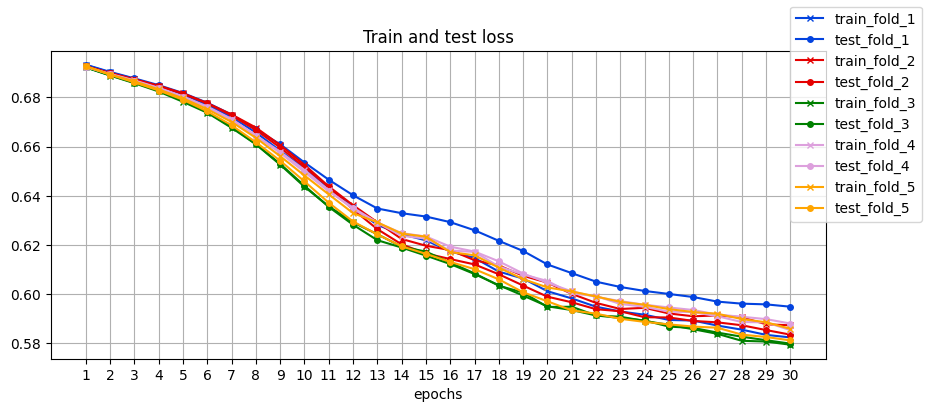

In [ ]:
# plot train and test loss
fig, ax = plt.subplots(figsize=(10,4))
colors = ['#0343DF', '#E50000', '#008000', '#DDA0DD', '#FFA500']
for i in range(n_fold):
    ax.plot(range(1,len(train_loss_all[i])+1), train_loss_all[i], '-x', markersize=4, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_loss_all[i])+1), test_loss_all[i], '-o', markersize=4, label=f'test_fold_{i+1}', color=colors[i])
ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test loss')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

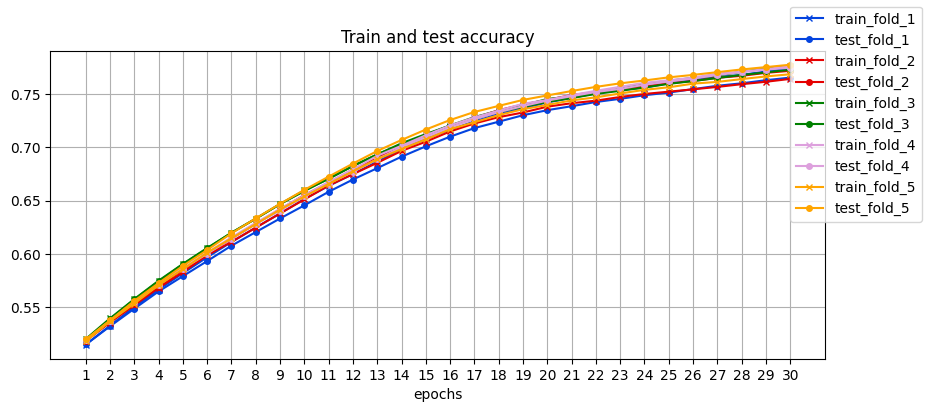

In [ ]:
# plot train and test accuracy
fig, ax = plt.subplots(figsize=(10,4))
for i in range(n_fold):
    ax.plot(range(1,len(train_acc_all[i])+1), train_acc_all[i], '-x', markersize=4, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_acc_all[i])+1), test_acc_all[i], '-o', markersize=4, label=f'test_fold_{i+1}', color=colors[i])
ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test accuracy')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

In [ ]:
# print out average accuracy
acc_list = []
for i in range(n_fold):
    acc = test_acc_all[i][-1]
    acc_list.append(acc)
    print(f'Fold {i+1} test accuracy: {acc:.4f}')
print('==============')
print(f'Average accuracy: {np.mean(acc_list):.4f}')

Fold 1 test accuracy: 0.7656
Fold 2 test accuracy: 0.7720
Fold 3 test accuracy: 0.7730
Fold 4 test accuracy: 0.7750
Fold 5 test accuracy: 0.7777
Average accuracy: 0.7727


### Inspect all folds output

In [ ]:
# combine and reorder the outputs
output_sorted = torch.zeros(num_nodes, num_features)

for i in range(n_fold):
    output = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GCN_800/fold_{i+1}.pt')   # load back saved outputs
    output_masked = output[[test_masks[i]]].cpu().detach()
    print(f'Fold {i+1} output: {output_masked.shape[0]} nodes')
    output_sorted[test_masks[i]] = output_masked   # put output of each folder back to the original order

print('==============')
print(f'All folds output: {output_sorted.shape[0]} nodes')

Fold 1 output: 1525 nodes
Fold 2 output: 1525 nodes
Fold 3 output: 1525 nodes
Fold 4 output: 1525 nodes
Fold 5 output: 1524 nodes
All folds output: 7624 nodes


In [ ]:
if save_results:
    torch.save(output_sorted, f'/content/drive/Shareddrives/CS523/Notebooks/output/GCN_800/all_folds.pt')

In [ ]:
output = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GCN_800/all_folds.pt')

In [ ]:
torch.where(output>=0.5, 1, 0).sum(axis=0)

tensor([6584, 6264, 5877, 5668, 4459, 5030, 4604, 5101, 4278, 5446, 3814, 4834,
        3380, 3900, 5169, 3892, 3384, 2705, 3123, 3098, 3947, 3364, 2543, 1732,
        3675, 2839, 2743, 2150, 1955, 2448, 2820, 2970, 2936, 2995, 2526, 2440,
        2656, 1604, 2370, 2632, 2071, 2033, 1621, 2120, 1997, 2635, 2263, 2015,
        2004, 1398, 2161, 1976, 1777, 1374, 2059, 2141, 1908, 1468, 2065, 1736,
        2341, 2058, 1158, 1365, 2501, 2740, 3012, 2248,  984, 1318, 1477, 2053,
        1993, 1566, 1274, 1351, 1684, 2160, 1194, 1026, 1403, 1237, 1544,  874,
        2029, 1391, 1995, 1307, 1075,  784, 1878, 1265, 1110,  997, 1029, 1120,
         845, 1163, 1433,  868,  615,  830,  940, 1415, 1464,  816,  711,  512,
         552,  854, 1473,  711, 1267, 1413,  606, 1451,  977,  973, 1017,  491,
        1805,  507, 1088,  615, 1179, 1003, 1074,  678,  669,  877,  826,  979,
         522, 1251,  636,  953,  943,  551,  733,  826,  360,  223,  679,  891,
         237, 1060,  778, 1275,  475,  5

In [ ]:
data.x.sum(axis=1).cpu()

tensor([268., 162.,  96.,  ..., 220., 272.,  86.])

In [ ]:
torch.where(output>=0.5, 1, 0).sum(axis=1)

tensor([137, 101,  98,  ...,  37,  39,  34])